# 2D 实验的notebook

1. 加载数据集
2. 定义模型
3. 开始训练
4. 评估

还要对比explicit和implicit，先搭一个implicit的框架，后面再慢慢优化。

## 加载数据集
- 数据集和验证集配置
- 分割数据集和验证集

In [12]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
ibc_parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(ibc_parent_dir)

from tqdm.auto import tqdm
from ibc import dataset, models, optimizers, trainer, utils
from scipy.spatial import ConvexHull
from ibc.trainer import PolicyType
from ibc import dataset_2d

许多超参需要调整，在这里调整吧

dataset的超参设置

In [13]:
experiment_name = "implicit_test_2d" # custom experiment name
custom_seed = 42 # custom seed

train_dataset_size = 30 # custom dataset size
train_batch_size = 8
trian_num_workers = 1

test_dataset_size = 500
test_batch_size = 8
test_num_workers = 1


训练的超参设置

In [14]:
# in_channels = 1 # 不需要卷积了吧，直接使用MLP试试
spatial_reduction = models.SpatialReduction.SPATIAL_SOFTMAX
policy_type = PolicyType
custom_dropout_prob = 0.1
custom_learning_rate = 0.001
custom_weight_decay = 0.0001

implicit = True # 选择显式or隐式
if implicit:
    policy_type = trainer.PolicyType.IMPLICIT
else:
    policy_type = trainer.PolicyType.EXPLICIT

In [15]:
train_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=train_dataset_size,
    seed=custom_seed,
)
train_dataset = dataset_2d.Toy1DDataset(train_dataset_config)  # data: coordinate regression shape:（N,2)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=trian_num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Test split.
test_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=test_dataset_size,
    seed=custom_seed, 
)
test_dataset = dataset_2d.Toy1DDataset(test_dataset_config)
test_dataset.exclude(train_dataset.coordinates) # 防止测试集中包含训练集的数据
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=test_num_workers,
    pin_memory=torch.cuda.is_available(),
)

Resampled 30 data points.


In [16]:
print(train_dataloader.dataset.get_target_bounds())

[[0.]
 [1.]]


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 1])
batch[1].shape:torch.Size([8, 1])
x = torch.Size([1])
y = torch.Size([1])


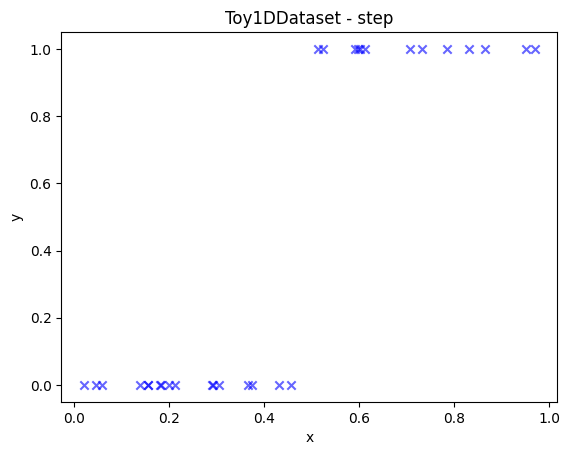

In [17]:
batch = next(iter(train_dataloader))    # 可以更改为test_dataloader查看测试集的shape

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

# Visualize one instance.
x, y = train_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)

xs = train_dataset.coordinates.flatten()
ys = train_dataset.targets.flatten()

plt.scatter(xs, ys, marker="x", c="blue", alpha=0.6)
plt.title(f"Toy1DDataset - {train_dataset_config.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 1])
batch[1].shape:torch.Size([8, 1])


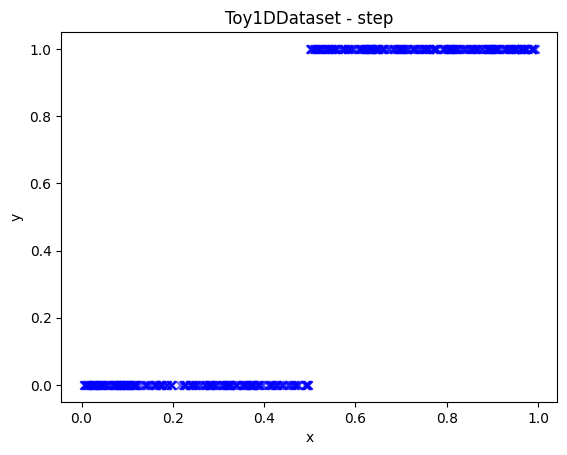

In [18]:
batch = next(iter(test_dataloader))    # 可以更改为test_dataloader查看测试集的shape

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

xs = test_dataset.coordinates.flatten()
ys = test_dataset.targets.flatten()

plt.scatter(xs, ys, marker="x", c="blue", alpha=0.6)
plt.title(f"Toy1DDataset - {test_dataset_config.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 构造网络模型

**配置网络参数**

网络与优化器配置：

In [ ]:
# residual_blocks = [16, 32, 32]  # 残差块的数量和通道数
# cnn_config = models.CNNConfig(in_channels, residual_blocks) # CNN配置
# print("in channels:", in_channels)

input_dim = 1  # We have a 1x1 conv that reduces to 16 channels.
output_dim = 1
# if spatial_reduction == models.SpatialReduction.SPATIAL_SOFTMAX:
#     input_dim *= 2
if policy_type == trainer.PolicyType.IMPLICIT:
    input_dim += 1  # Dimension of the targets. o+a
    print("input dimension:", input_dim)
    output_dim = 1

print("input dimension:", input_dim)

mlp_config = models.MLPConfig(
    input_dim=input_dim,
    hidden_dim=128,
    output_dim=output_dim,
    hidden_depth=2,
    dropout_prob=custom_dropout_prob,
)

# model_config = models.ConvMLPConfig(
#     cnn_config=cnn_config,
#     mlp_config=mlp_config,
#     spatial_reduction=spatial_reduction,
#     coord_conv=coord_conv,
# )

optim_config = optimizers.OptimizerConfig(
    learning_rate=custom_learning_rate,
    weight_decay=custom_weight_decay,
)

input dimension: 2


打印配置：

In [20]:
print("mlp_config:", mlp_config)
print("optim_config:", optim_config)
net = models.EBMMLP(mlp_config)
print("The network structure is: \n", net)
print("The whole network has {} parameters".format(sum(p.numel() for p in net.parameters())))

mlp_config: MLPConfig(input_dim=2, hidden_dim=128, output_dim=1, hidden_depth=2, dropout_prob=0.1, activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>)
optim_config: OptimizerConfig(learning_rate=0.001, weight_decay=0.0001, beta1=0.9, beta2=0.999, lr_scheduler_step=100, lr_scheduler_gamma=0.99)
The network structure is: 
 EBMMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
The whole network has 17025 parameters


创建训练进程：

In [21]:
train_state: trainer.TrainStateProtocol
if policy_type == trainer.PolicyType.EXPLICIT:
    train_state = trainer.ExplicitTrainState.initialize(
        model_config=mlp_config,
        optim_config=optim_config,
        device_type="cuda",
    )
else:
    target_bounds = train_dataloader.dataset.get_target_bounds()
    stochastic_optim_config = optimizers.DerivativeFreeConfig(
        bounds=target_bounds,
        train_samples=128,
    )

    train_state = trainer.ImplicitTrainState2D.initialize(
        model_config=mlp_config,
        optim_config=optim_config,
        stochastic_optim_config=stochastic_optim_config,
        device_type="cuda",
    )

Using device: cuda


把训练的细节搬到这里

## 开始训练

In [22]:
from ibc.experiment import Experiment
experiment = Experiment(
    identifier = experiment_name, # custom experiment name
).assert_new()

checkpoint_every_n_steps = 100
eval_every_n_steps = 1000
log_every_n_steps = 10

In [23]:
input, target = batch
print("input:", input.shape)
print("target:", target.shape)

input: torch.Size([8, 1])
target: torch.Size([8, 1])


In [24]:
for epoch in tqdm(range(2000)):
    if not train_state.steps % checkpoint_every_n_steps:
        experiment.save_checkpoint(train_state, step=train_state.steps)

    if not train_state.steps % eval_every_n_steps:
        test_log_data = train_state.evaluate(test_dataloader)
        experiment.log(test_log_data, step=train_state.steps)

    for batch in train_dataloader:
        train_log_data = train_state.training_step(*batch)

        # Log to tensorboard.
        if not train_state.steps % log_every_n_steps:
            experiment.log(train_log_data, step=train_state.steps)

# Save one final checkpoint.
experiment.save_checkpoint(train_state, step=train_state.steps)

100%|██████████| 2000/2000 [01:27<00:00, 22.78it/s]


## Evaluation

In [25]:
import dataclasses
import pathlib

from plot import plot

In [26]:
@dataclasses.dataclass
class Args:
    # experiment_name: experiment_name  # drop了，在后面的代码直接指定
    plot_dir: str = "assets"
    dpi: int = 200
    threshold: float = 140

dataset_test = test_dataloader.dataset
dataset_train = train_dataloader.dataset
assert isinstance(dataset_test, dataset_2d.Toy1DDataset)
assert isinstance(dataset_train, dataset_2d.Toy1DDataset)

In [27]:
batch = next(iter(test_dataloader))
# 假设第0个元素是输入x，第1个元素是标签y
print("输入x的形状:", batch[0].shape)
print("标签y的形状:", batch[1].shape)

输入x的形状: torch.Size([8, 1])
标签y的形状: torch.Size([8, 1])


In [28]:
total_mse = 0.0
num_small_err = 0
all_inputs = []
all_preds = []
all_targets = []

for batch in tqdm(test_dataloader):
    input, target = batch
    prediction = train_state.predict(input).cpu().numpy()
    target = target.cpu().numpy()

    all_inputs.append(input.cpu().numpy())
    all_preds.append(prediction)
    all_targets.append(target)


    # error
    diff = prediction - target
    error = np.asarray(np.linalg.norm(diff, axis=1))
    num_small_err += len(error[error < 1.0])
    total_mse += (diff ** 2).mean(axis=1).sum()


total_test = len(dataset_test)
average_mse = total_mse / total_test
print(f"Test set MSE: {average_mse} ({num_small_err}/{total_test})")

100%|██████████| 63/63 [00:00<00:00, 156.71it/s]


Test set MSE: 0.016 (492/500)


In [29]:
print("experiment_name:", experiment.identifier)

experiment_name: implicit_test_2d


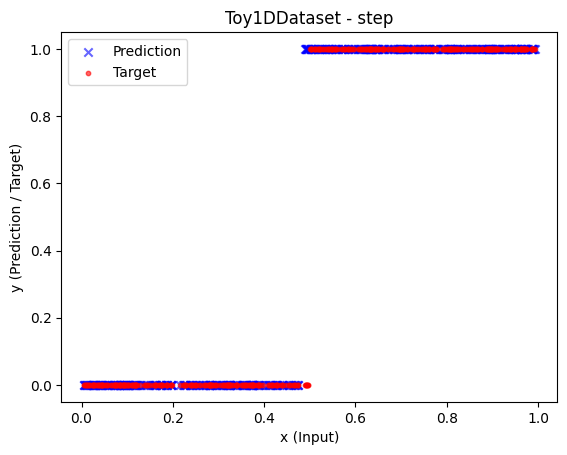

In [30]:
# all_inputs, all_preds, all_targets 已经是每个 batch 的 numpy 数组
xs = np.concatenate(all_inputs, axis=0).flatten()
ys_pred = np.concatenate(all_preds, axis=0).flatten()
ys_target = np.concatenate(all_targets, axis=0).flatten()


# 2. 绘制第一组：input-x 与 prediction（原有逻辑，保持不变）
plt.scatter(
    xs, ys_pred, 
    marker="x",    # 标记为"x"（区分目标值）
    c="blue",      # 颜色为蓝色
    alpha=0.6,     # 透明度0.6（避免重叠遮挡）
    label="Prediction"  # 标签（用于图例）
)

# 3. 新增：绘制第二组：input-x 与 target（关键新增代码）
plt.scatter(
    xs, ys_target, 
    marker="o",    # 标记为"圆圈"（与预测值区分）
    c="red",       # 颜色为红色（与蓝色对比明显）
    alpha=0.6,     # 透明度0.6（与预测值一致）
    s=10,          # 标记大小（可选，避免过大遮挡）
    label="Target" # 标签（用于图例）
)

# 4. 原有图表配置（保持不变，可补充图例）
plt.title(f"Toy1DDataset - {train_dataset_config.mode}")
plt.xlabel("x (Input)")       # 明确x轴含义（input值）
plt.ylabel("y (Prediction / Target)")  # 明确y轴含义（包含预测和目标）
plt.legend()  # 显示图例（区分两组数据，关键！）
plt.show()